# Pengembangan Sistem Rekomendasi Film Dengan Teknik Content-based Filtering

# Import Library

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


# Datasets Understanding

## Data Loading

In [52]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parasharmanas/movie-recommendation-system")
df = pd.read_csv(path + "/movies.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


menggunakan library kagglehub langsung untuk mengambil dataset

Ada 62423 Baris data dalam datasets tersebut, dengan jumlah fitur sebanyak 3


# Analysis Variable

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


Dataset ini berisi judul film dan genre" nya

In [54]:
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [55]:
unique_genres = [i for i in df["genres"].str.split("|").explode().unique() if i]
print(f"Unique genres: {len(unique_genres)}")
print(unique_genres)

Unique genres: 20
['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)']


Melakukan processing sederhana dengan cara menghilangkan "|" untuk melihat jumlah genre yang ada

terdapat 20 unique genre

In [56]:
mask = df['genres'].str.contains('(no genres listed)')
df[mask]

C:\Users\alfth\AppData\Local\Temp\ipykernel_20744\1614034987.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df['genres'].str.contains('(no genres listed)')


,movieId,title,genres
15881,83773,Away with Words (San tiao ren) (1999),(no genres listed)
16060,84768,Glitterbug (1994),(no genres listed)
16351,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed)
16491,87061,Trails (Veredas) (1978),(no genres listed)
17404,91246,Milky Way (Tejút) (2007),(no genres listed)
...,...,...,...
62400,209101,Hua yang de nian hua (2001),(no genres listed)
62401,209103,Tsar Ivan the Terrible (1991),(no genres listed)
62407,209133,The Riot and the Dance (2018),(no genres listed)
62415,209151,Mao Zedong 1949 (2019),(no genres listed)


Terdapat 5062 baris data dengan genre "no genres listed". Entri ini dikategorikan sebagai missing value karena content-based filtering memerlukan informasi genre. Karena genre tersebut tidak dapat diidentifikasi, baris data ini akan dihapus (drop). Mengingat volume data keseluruhan yang besar, penghapusan ini diperkirakan tidak akan berdampak signifikan.

In [57]:
df = df[~mask]
df.shape

(57361, 3)

In [58]:
df.describe(include='all')

,movieId,title,genres
count,57361.000000,57361,57361
unique,NaN,57278,1638
top,NaN,Simple Things (2007),Drama
freq,NaN,2,9056
mean,118736.994753,NaN,NaN
std,64472.143127,NaN,NaN
min,1.000000,NaN,NaN
25%,74480.000000,NaN,NaN
50%,133697.000000,NaN,NaN
75%,172299.000000,NaN,NaN


Karena data masih berupa object string, maka method describe tidak bisa memberikan gambaran statistik umum secara detail. perlu di lakukan preprocessing terlebih dahulu

# Handle Missing Value

In [59]:
df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Tidak terdapat missing value dalam dataset ini

## Handle Duplicated Values

In [60]:
df['title'].duplicated().sum()

np.int64(83)

Terdapat 83 judul film yang sama dalam dataset

In [61]:
df[df['title'].duplicated(keep=False)].sort_values('title')

,movieId,title,genres
61103,204982,9 (2009),Comedy
13713,71057,9 (2009),Adventure|Animation|Sci-Fi
30628,136696,Absolution (2015),Action|Adventure|Crime|Thriller
37060,151797,Absolution (2015),Drama|Thriller
580,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
...,...,...,...
49653,179333,Veronica (2017),Horror
10055,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
12909,64997,War of the Worlds (2005),Action|Sci-Fi
17391,91199,Weekend (2011),Drama|Romance


Dari hasil filtering diatas, dapat dilihat bahwa terdapat beberapa film yang memiliki entri lebih dari 1 dengan genre dan id yang berbeda. Dalam studi kasus ini, data duplikat akan drop, dan hanya keep salah satu entri saja untuk menyederhanakan proses dan menghindari bias genre

In [62]:
df.drop_duplicates(subset='title', inplace=True)
df.shape

(57278, 3)

In [63]:
df[df['title'].duplicated(keep=False)].sort_values('title')

,movieId,title,genres


Data duplikat telah hilang

# Univariate Analysis

C:\Users\alfth\AppData\Local\Temp\ipykernel_20744\3974478389.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


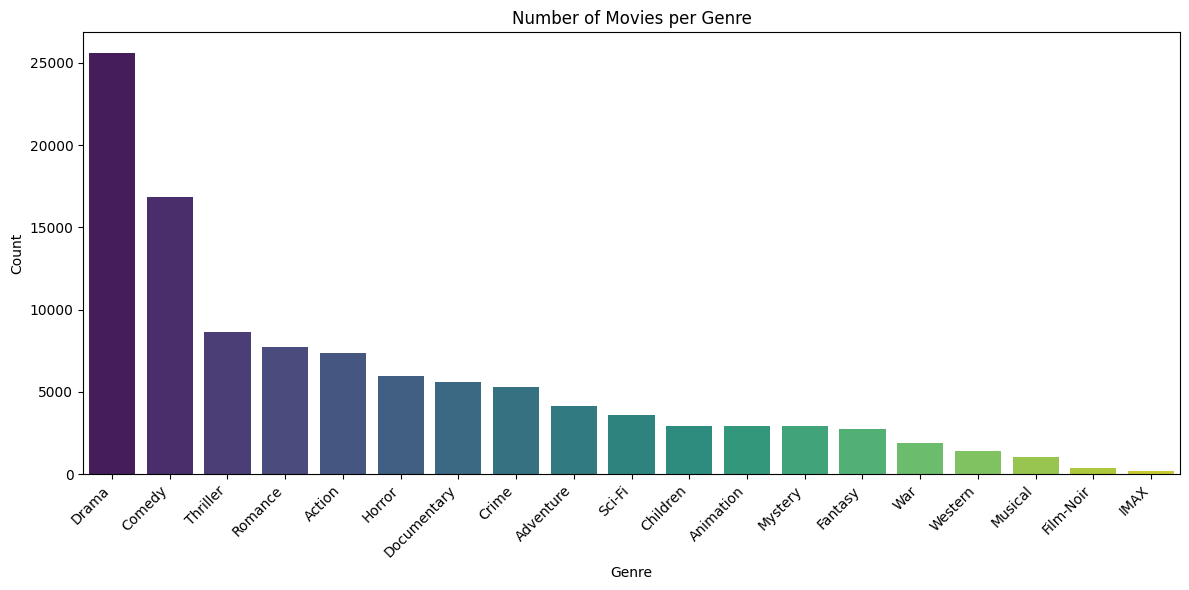

In [64]:


genre_counts = df['genres'].str.split('|').explode().value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Menganalisis jumlah kemunculan genre per film. Dapat dilihat genre "Drama" menjadi genre yang paling banyak ada di data film tersebut

# Data Preparation

## Memisahkan String Genre menjadi Daftar (List)

In [66]:
# Membuat kolom baru berisi daftar genre
df['genres_list'] = df['genres'].str.split('|')

print("\nDataset dengan Kolom 'genres_list':")
df


Dataset dengan Kolom 'genres_list':


,movieId,title,genres,genres_list
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]
...,...,...,...,...
62417,209155,Santosh Subramaniam (2008),Action|Comedy|Romance,"[Action, Comedy, Romance]"
62418,209157,We (2018),Drama,[Drama]
62419,209159,Window of the Soul (2001),Documentary,[Documentary]
62420,209163,Bad Poems (2018),Comedy|Drama,"[Comedy, Drama]"


Kolom genres saat ini berisi satu string panjang yang dipisahkan oleh pipa (|). Kita perlu mengubahnya menjadi daftar (list) dari setiap genre.

## Encoding Genre

Ini adalah langkah paling penting. Kita perlu mengubah daftar genre menjadi representasi numerik. Metode yang cocok dalam format data seperti ini yaitu menggunakan MultiLabelBinarizer dari Scikit-learn, yang secara efektif melakukan hal serupa untuk data multi-label.

In [76]:


mlb = MultiLabelBinarizer()

# Terapkan MultiLabelBinarizer ke kolom 'genres_list'
genre_encoded = pd.DataFrame(
    mlb.fit_transform(df['genres_list']),
    columns=mlb.classes_,
    index=df.index
)

print("\nGenre yang Sudah di-Encode (One-Hot Encoded):")
genre_encoded.head()



Genre yang Sudah di-Encode (One-Hot Encoded):


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:


df_processed = pd.concat([df[['movieId', 'title']], genre_encoded], axis=1)

print("\nDataset Final yang Siap untuk Content-Based Filtering:")
df_processed


Dataset Final yang Siap untuk Content-Based Filtering:


,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62417,209155,Santosh Subramaniam (2008),1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
62418,209157,We (2018),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
62419,209159,Window of the Soul (2001),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
62420,209163,Bad Poems (2018),0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Output hasil encoding diatas merupakan representasi fitur penting dari setiap genre dengan menggunakan multilabel binarizer. Setiap genre unik akan menjadi sebuah kolom baru. Untuk setiap film, kolom genre tersebut akan bernilai 1 jika film tersebut memiliki genre itu, dan 0 jika tidak.

# Modelling

Pemilihan Algoritma

Pendekatan yang dipilih adalah sebagai berikut:

- Nearest Neighbors:

    - Sederhana & Intuitif: Mudah dipahami dan diimplementasikan.
    - Efektif Mencari Kemiripan: Bagus untuk menemukan item serupa atau melakukan rekomendasi.
    - Fleksibel: Tidak memerlukan asumsi kuat tentang distribusi data.

- Cosine Similarity on-demand:

    - Hemat Memori & Komputasi: Menghindari pembuatan matriks similaritas besar yang boros memori, dihitung hanya saat perlu. Ini penting - untuk   skalabilitas, terutama pada dataset besar.
    - Cocok untuk Data Jarang & Dimensi Tinggi: Efektif untuk data seperti teks atau interaksi pengguna-item, di mana banyak nilai adalah nol.

## Nearest Neighbors

In [100]:
nn_model = NearestNeighbors(n_neighbors=11, metric='euclidean', algorithm='ball_tree')
nn_model.fit(genre_encoded.values)


NearestNeighbors(algorithm='ball_tree', metric='euclidean', n_neighbors=11)

### Inference

In [136]:
def get_recommendations_with_nn(movie_index, nn_model_trained, movie_titles_list, movie_genre_list, all_movie_features, top_n=10):
    if movie_index >= len(all_movie_features):
        print("Indeks film tidak valid.")
        return pd.DataFrame()

    target_movie_vector = all_movie_features[movie_index].reshape(1, -1)
    distances, indices = nn_model_trained.kneighbors(target_movie_vector,n_neighbors=top_n+1)

    recs = []
    for i in range(1, len(indices[0])):
        neighbor_index = indices[0][i]
        similarity_score = 1 - distances[0][i]
        recs.append({
            'title': movie_titles_list[neighbor_index],
            'genres': movie_genre_list[neighbor_index],
            'similarity_score': similarity_score,
            'distance': distances[0][i]
        })
    print(f"Rekomendasi untuk film: {movie_titles_list[movie_index]} {movie_genre_list[movie_index]}")
    return pd.DataFrame(recs)

movie_titles = df['title'].values
movie_genres = df['genres_list'].values

recommendations_df = get_recommendations_with_nn(0, nn_model, movie_titles, movie_genres, genre_encoded.values)
recommendations_df

Rekomendasi untuk film: Toy Story (1995) ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']


,title,genres,similarity_score,distance
0,Asterix and the Vikings (Astérix et les Viking...,"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0
1,"Wild, The (2006)","[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0
2,"Tale of Despereaux, The (2008)","[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0
3,Toy Story 2 (1999),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0
4,"Monsters, Inc. (2001)","[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0
5,DuckTales: The Movie - Treasure of the Lost La...,"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0
6,Shrek the Third (2007),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0
7,"Adventures of Rocky and Bullwinkle, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0
8,Antz (1998),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0
9,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,0.0


Dalam algoritma Nearest Neighbors, digunakan metrik Euclidean sebagai pengukur kemiripan antar film berdasarkan representasi genre yang telah di-encode. Algoritma `ball_tree` dipilih karena efisien untuk data berdimensi tinggi dan dapat mempercepat proses pencarian tetangga terdekat pada dataset yang besar. Dengan pendekatan ini, sistem dapat merekomendasikan film-film yang memiliki kemiripan genre secara optimal dan efisien.

## Cosine Similarity On-Demand

In [ ]:
def get_recommendations_on_demand(movie_index, all_movie_features, movie_titles_list, movie_genre_list, top_n=10):
    if movie_index >= len(all_movie_features):
        print("Indeks film tidak valid.")
        return pd.DataFrame()

    target_movie_vector = all_movie_features[movie_index].reshape(1, -1)
    similarity_scores = cosine_similarity(target_movie_vector, all_movie_features)
    similarity_scores_for_target = similarity_scores[0]

    movie_similarity_pairs = list(enumerate(similarity_scores_for_target))
    sorted_similar_movies = sorted(movie_similarity_pairs, key=lambda x: x[1], reverse=True)

    recs = []
    for i, score in sorted_similar_movies:
        if i == movie_index:
            continue
        if len(recs) < top_n:
            recs.append({
                'title': movie_titles_list[i],
                'genres': movie_genre_list[i],
                'similarity_score': score
            })
        else:
            break

    print(f"Rekomendasi untuk film: {movie_titles_list[movie_index]} {movie_genre_list[movie_index]}")
    return pd.DataFrame(recs)

get_recommendations_on_demand(0, genre_encoded.values, movie_titles, movie_genres)

Rekomendasi untuk film: Toy Story (1995) ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']


,title,genres,similarity_score
0,Antz (1998),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0
1,Toy Story 2 (1999),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0
2,"Adventures of Rocky and Bullwinkle, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]",1.0
3,"Emperor's New Groove, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]",1.0
4,"Monsters, Inc. (2001)","[Adventure, Animation, Children, Comedy, Fantasy]",1.0
5,DuckTales: The Movie - Treasure of the Lost La...,"[Adventure, Animation, Children, Comedy, Fantasy]",1.0
6,"Wild, The (2006)","[Adventure, Animation, Children, Comedy, Fantasy]",1.0
7,Shrek the Third (2007),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0
8,"Tale of Despereaux, The (2008)","[Adventure, Animation, Children, Comedy, Fantasy]",1.0
9,Asterix and the Vikings (Astérix et les Viking...,"[Adventure, Animation, Children, Comedy, Fantasy]",1.0


Pada algoritma cosine similarity on demand, perhitungan cosine similarity dilakukan saat proses inference, yaitu dengan membandingkan film yang dicari terhadap seluruh film yang ada. Sistem kemudian mengembalikan daftar film dengan tingkat kemiripan tertinggi berdasarkan genre dengan film yang dicari.

# Evaluation

# Precision

## Penjelasan Metric Precision pada Sistem Rekomendasi

**Precision** dalam sistem rekomendasi mengukur seberapa relevan item yang direkomendasikan terhadap kebutuhan pengguna. Dalam konteks sistem rekomendasi film berbasis genre seperti pada notebook ini, precision dihitung sebagai proporsi film yang direkomendasikan yang benar-benar memiliki genre target (misal: "Comedy") dari seluruh film yang direkomendasikan.


Precision penting untuk menilai kualitas rekomendasi: semakin tinggi precision, semakin banyak rekomendasi yang benar-benar sesuai dengan preferensi pengguna (genre yang dicari)

In [142]:
def calculate_precision(
    index_movie: int,
    df_recommendations: pd.DataFrame,
    n: int = 10
) -> float:
    """
    Menghitung Precision@N berdasarkan apakah film yang direkomendasikan
    memiliki setidaknya satu genre yang sama dengan film input (berdasarkan index).
    """
    if df_recommendations.empty or n == 0:
        return 0.0

    # Ambil set genre dari df berdasarkan index_movie
    input_genres = set(df.iloc[index_movie]['genres_list'])
    if not input_genres:
        return 0.0

    num_to_check = min(n, len(df_recommendations))
    relevant = 0

    for i in range(num_to_check):
        rec_genres = set(df_recommendations.iloc[i]['genres'])
        if input_genres & rec_genres:
            relevant += 1

    print(f"Precision@{n} untuk film {df.iloc[index_movie]['title']}: {relevant}/{num_to_check}")




In [139]:
nn_recommendations = get_recommendations_with_nn(0, nn_model, movie_titles, movie_genres, genre_encoded.values)
calculate_precision(0, nn_recommendations, n=10)

Rekomendasi untuk film: Toy Story (1995) ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']
Precision@10 untuk film Toy Story (1995): 10/10


In [140]:
cosine_recommendations = get_recommendations_on_demand(0, genre_encoded.values, movie_titles, movie_genres)
calculate_precision(0, cosine_recommendations, n=10)

Rekomendasi untuk film: Toy Story (1995) ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']
Precision@10 untuk film Toy Story (1995): 10/10


### Hasil Evaluasi Precision

Berdasarkan hasil evaluasi precision pada sistem rekomendasi film berbasis content-based filtering di atas, diperoleh nilai **Precision@10 = 1.0** untuk kedua metode (Nearest Neighbors dan Cosine Similarity). Artinya, dari 10 film yang direkomendasikan untuk film input (misal: "Toy Story (1995)"), seluruh film yang direkomendasikan memiliki setidaknya satu genre yang sama dengan film input tersebut.

Nilai precision yang tinggi ini menunjukkan bahwa sistem rekomendasi mampu memberikan rekomendasi yang sangat relevan secara genre. Dengan kata lain, setiap film yang direkomendasikan memang sesuai dengan preferensi genre dari film yang dicari, sehingga sistem efektif dalam menyaring film yang benar-benar mirip dari sisi konten (genre).

Namun, perlu diingat bahwa precision hanya mengukur relevansi genre, bukan kualitas keseluruhan rekomendasi (misal: popularitas, rating, atau faktor lain di luar genre). Precision yang tinggi sangat penting untuk memastikan pengguna mendapatkan rekomendasi yang sesuai dengan minat awalnya.